<a href="https://colab.research.google.com/github/JomoGeorgeSmith/melnet/blob/main/melnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jomosmith","key":"ea24b718a2d830c5f75e26146e86a91e"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
%cd /content/drive/MyDrive/melnet/data


/content/drive/MyDrive/melnet/data


In [6]:
!kaggle datasets download -d drscarlat/melanoma


100% 5.26G/5.26G [04:52<00:00, 19.7MB/s]
100% 5.26G/5.26G [04:52<00:00, 19.3MB/s]


In [9]:
!unzip /content/drive/MyDrive/melnet/data/melanoma.zip

Streaming output truncated to the last 5000 lines.
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031354.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031355.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031357.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031358.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031362.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031363.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031365.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031366.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031367.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031370.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031375.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031380.jpg  
  inflating: dermmel/DermMel/train_sep/NotMelanoma/ISIC_0031382.jpg  
  inflating: dermmel/DermMel/train_sep/

In [10]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.layers import  SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Conv2D, Flatten, Dropout, Dense , BatchNormalization, ReLU
from keras import layers, models,  Model
from keras.layers import SpatialDropout2D
from keras.applications import VGG16
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , LearningRateScheduler, CSVLogger, ModelCheckpoint
from keras.optimizers import RMSprop, Adam
from skimage import transform
import random
import matplotlib.pyplot as plt
from PIL import Image
from skimage.util import random_noise
from skimage import exposure, color, transform
from scipy.ndimage import gaussian_filter
from skimage.transform import rotate, rescale
from keras.applications import ResNet50
from keras.metrics import Precision, Recall
from tensorflow import keras

In [11]:
# Directories
train_dir = '/content/drive/MyDrive/melnet/data/DermMel/train_sep'

val_dir = '/content/drive/MyDrive/melnet/data/DermMel/valid'

In [12]:
# ImageDataGenerator for training data with aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300,300),
    batch_size=35,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(300,300),
    batch_size=35,
    class_mode='binary'

)


Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.


In [13]:
# Load the saved model

model_path = '/content/drive/MyDrive/melnet/models/melnet_cnn_resnet_2_fine_tuned.h5'


In [14]:
# Load the base model
base_model = keras.models.load_model(model_path)

layers_to_remove = ['dense', 'flatten' ,'conv5_block3_out']

# Remove layers by their names
for layer_name in layers_to_remove:
    base_model = keras.models.Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

x = base_model.output
x = Conv2D(512, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)  # Adding back the Flatten layer
x = Dense(256, activation='relu')(x)  # Adding back the first Dense layer
predictions = Dense(1, activation='sigmoid')(x)  # Adding back the last Dense layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 306, 306, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [15]:
# Learning rate scheduler
def lr_scheduler(epoch):
    return 1e-5

lr_schedule = LearningRateScheduler(lr_scheduler)

early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7)

checkpoint_filepath = '/content/drive/MyDrive/melnet/models/checkpoint_melnet_cnn_resnet_2_fine_tuned_added_conv2d.h5'

# Define the ModelCheckpoint callback to save the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max', # Save the model when the validation accuracy is maximized
    verbose=1
)

# Add ModelCheckpoint callback to the list of callbacks
callbacks = [early_stopping, lr_schedule, learning_rate_reduction, model_checkpoint]

# Train the model with the updated list of callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_steps=28,
    callbacks=callbacks
)

model.save('/content/drive/MyDrive/melnet/models/melnet_cnn_resnet_2_fine_tuned_added_conv2d.h5')

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.7989 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.49286, saving model to /content/drive/MyDrive/melnet/models/checkpoint_melnet_cnn_resnet_2_fine_tuned_added_conv2d.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 148s 1s/step - loss: 0.7989 - accuracy: 0.5714 - val_loss: 0.6731 - val_accuracy: 0.4929 - lr: 1.0000e-05
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.7159 - accuracy: 0.5971
Epoch 2: val_accuracy improved from 0.49286 to 0.50612, saving model to /content/drive/MyDrive/melnet/models/checkpoint_melnet_cnn_resnet_2_fine_tuned_added_conv2d.h5
100/100 [==============================] - 131s 1s/step - loss: 0.7159 - accuracy: 0.5971 - val_loss: 0.7327 - val_accuracy: 0.5061 - lr: 1.0000e-05
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.6577
Epoch 3: val_accuracy improved from 0.50612 to 0.73163, saving model to /content/drive/MyDrive/melnet/models/checkpoint_melnet_cnn_resnet_2_fine_tuned_added_conv2d.h5
100/100 [==============================] - 139s 1s/step - loss: 0.6436 - accuracy: 0.6577 - val_loss: 0.5961 - val_accuracy: 0.7316 - lr: 1.0000e-05
Epoch 4/50
100/100 [=======

# HEATMAP

In [9]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from keras import backend as K
tf.compat.v1.disable_eager_execution()

In [10]:

def load_and_preprocess_image(image_path, target_size=(300, 300)):
    img = Image.open(image_path).resize(target_size)
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img

def preprocess_image(image):
    image = image.resize((300, 300))
    image = np.array(image)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

model_path = '/content/drive/MyDrive/melnet/models/checkpoint_melnet_cnn_resnet_2_fine_tuned_added_conv2d.h5'

model = keras.models.load_model(model_path)

print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 306, 306, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

Pooled Gradients: [ 0.0000000e+00 -3.1990065e-05]
Convolutional Layer Output: [[[0.         1.0638554  1.0435752  ... 0.         0.88636744 0.60821015]
  [0.         1.0500016  1.1674577  ... 0.         0.7779355  0.60057324]
  [0.         1.1474664  1.2066481  ... 0.         1.1756539  0.9291966 ]
  ...
  [0.         0.41944173 1.5243303  ... 0.         0.9394199  0.9188687 ]
  [0.         1.6740345  1.4715247  ... 0.         0.44189584 0.27096093]
  [0.         2.8904316  1.3046135  ... 0.         0.58947825 0.18755633]]

 [[0.         1.4907792  1.2220166  ... 0.         1.1836904  0.7898853 ]
  [0.         1.5914502  1.1591301  ... 0.         1.9193742  0.69663775]
  [0.         1.4634598  1.0732927  ... 0.         2.637114   0.886247  ]
  ...
  [0.         0.61897194 0.8889096  ... 0.         0.6616998  0.9781889 ]
  [0.         2.5058548  1.2300882  ... 0.         0.49891898 0.7363259 ]
  [0.         2.461865   0.88086045 ... 0.         0.82852817 1.3070343 ]]]


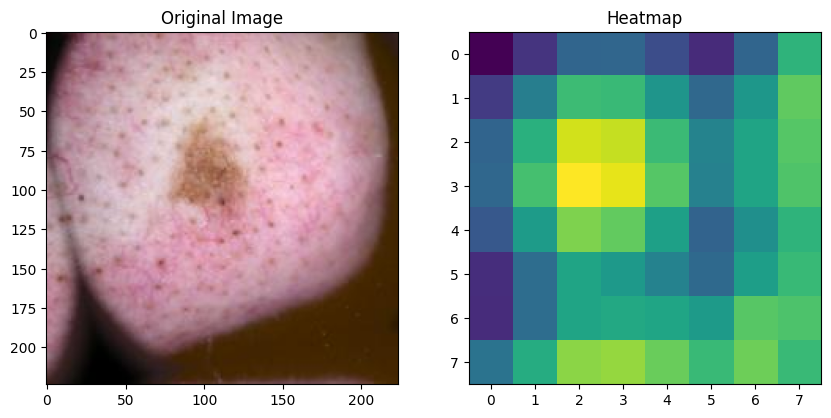

In [32]:
img_path = '/content/drive/MyDrive/melnet/data/dermmel/DermMel/train_sep/Melanoma/AUG_0_1013.jpeg'
x = load_and_preprocess_image(img_path)

last_conv_layer = model.get_layer('conv2d')
model_output = model.output

grads = K.gradients(model_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))


iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])


print("Pooled Gradients:", pooled_grads_value[:2])
print("Convolutional Layer Output:", conv_layer_output_value[:2])

for i in range(conv_layer_output_value.shape[0]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(Image.open(img_path))
axs[0].set_title('Original Image')
axs[1].imshow(heatmap, cmap='viridis')
axs[1].set_title('Heatmap')
plt.show()

# Overlay heatmap on the original image
img = cv2.imread(img_path)
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap_resized, 0.4, 0)

output_path = '/content/drive/MyDrive/melnet/data/heatmaps/superimposed_image_1.jpg'
cv2.imwrite(output_path, superimposed_img)

image = Image.open(img_path)
image = preprocess_image(image)
prediction = model.predict(image)
prediction_percentage = prediction[0][0] * 100

In [21]:
result = {
    "prediction": f"The model predicts melanoma (Cancerous) at {prediction_percentage:.2f}%" if prediction_percentage >= 50 else f"The model predicts no melanoma (Non - Cancerous) at {prediction_percentage:.2f}%",
}
print(result)

{'prediction': 'The model predicts melanoma (Cancerous) at 78.10%'}
